In [40]:
from itertools import product
import sys
sys.path.append('./rpa/')

In [41]:
import numpy as np

from pytriqs.gf import Gf, MeshBrillouinZone, MeshImFreq, Idx
from pytriqs.lattice.lattice_tools import BrillouinZone as BrillouinZone
from pytriqs.lattice.lattice_tools import BravaisLattice as BravaisLattice
from pytriqs.operators.util import U_matrix_kanamori, h_int_kanamori

from pyed.OperatorUtils import fundamental_operators_from_gf_struct


from triqs_tprf.rpa_tensor import get_rpa_tensor
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
from triqs_tprf.lattice import lattice_dyson_g0_wk
from triqs_tprf.lattice import solve_rpa_PH
from triqs_tprf.lattice_utils import k_space_path

In [42]:
# Here are the models stored to obtain the Hamiltonian in k-space.
from hamiltonian import Hubbard, T2G

import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
plt.style.use('notebook_style')

---

In [44]:
# Load the data to benchmark with
rpa_data = np.load('rpa_results.npz')

bench_chi0_hubbard = rpa_data['chi0_hubbard']
bench_chi_rpa_hubbard = rpa_data['chi_rpa_hubbard']
bench_chi0_t2g = rpa_data['chi0_t2g']
bench_chi_rpa_t2g = rpa_data['chi_rpa_t2g']

## Hubbard Model

In [45]:
nk = 10

ham_hubbard_parameters = {"k_mesh" : (nk, nk, nk),
                          "t" : 1.0,
                          "TRIQS": True, # Use the BZ mesh as in TRIQS
                         "spin": True}
ham_hubbard = Hubbard(**ham_hubbard_parameters)

In [46]:
assert nk**3 == bench_chi_rpa_hubbard.shape[1], 'The bechnmark data uses a different k-mesh!'

In [47]:
no = ham_hubbard.hamK.shape[-1]

units = [(1,0,0), (0,1,0), (0,0,1)]
orbital_positions = [(0, 0, 0)]
bl = BravaisLattice(units, orbital_positions)
bz = BrillouinZone(bl)
periodization_matrix = nk * np.eye(3, dtype=np.int32)
kmesh = MeshBrillouinZone(bz, periodization_matrix)

e_k = Gf(mesh=kmesh, target_shape=[no, no])

e_k.data[:] = ham_hubbard.hamK.reshape(nk**3, no, no)

In [48]:
G = np.array([0.0, 0.0, 0.0]) * 2.*np.pi
X = np.array([0.5, 0.0, 0.0]) * 2.*np.pi
M = np.array([0.5, 0.5, 0.0]) * 2.*np.pi
R = np.array([0.5, 0.5, 0.5]) * 2.*np.pi

paths = [(G, X), (X, M), (M, R), (R,G)]

k_vecs, k_plot, K_plot = k_space_path(paths)
kx, ky, kz = k_vecs.T

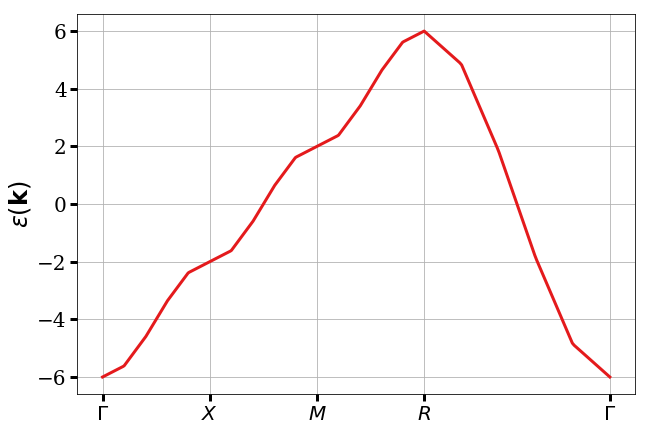

In [49]:
e_k_interp = np.vectorize(
    lambda kx, ky, kz : e_k([kx, ky, kz])[0, 0].real)
e_k_interp = e_k_interp(kx, ky, kz)

plt.plot(k_plot, e_k_interp, '-')
plt.axes().set_xticks(K_plot)
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
plt.ylabel(r'$\epsilon(\mathbf{k})$'); plt.grid()


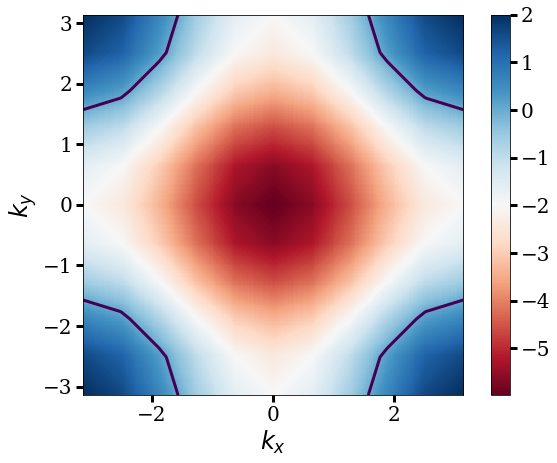

In [50]:
k = np.linspace(-0.5, 0.5, num=200) * 2. * np.pi
Kx, Ky = np.meshgrid(k, k)

e_k_interp = np.vectorize(lambda kx, ky : e_k([kx, ky, 0])[0, 0].real)
e_k_interp = e_k_interp(Kx, Ky)

plt.figure()
extent = (k.min(), k.max(), k.min(), k.max())
plt.imshow(e_k_interp, cmap=plt.get_cmap('RdBu'),
           extent=extent, origin='lower')
plt.colorbar()
plt.contour(Kx, Ky, e_k_interp, levels=[0], extent=extent)
plt.xlabel(r'$k_x$'); plt.ylabel(r'$k_y$');

In [51]:
wmesh = MeshImFreq(beta=10.0, S='Fermion', n_max=512)
g0_wk = lattice_dyson_g0_wk(mu=0.0, e_k=e_k, mesh=wmesh)

In [52]:
chi00_wk = imtime_bubble_chi0_wk(g0_wk, nw=1)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 10.0
nk    = 1000
nw    = 1024
norb  = 2

Approx. Memory Utilization: 0.31 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_w0r_from_grt_PH (bubble in tau & r)
--> chi_wk_from_chi_wr (r->k)


In [53]:
U = 1.0
J = 0.0

In [54]:
n_orb = 1
spin_names = ['up', 'do']
orb_names = range(n_orb)

gf_struct = [ [spin_name, orb_names] for spin_name in spin_names ]
Umat, Upmat = U_matrix_kanamori(n_orb=n_orb, U_int=U, J_hund=J)
H_int = h_int_kanamori(spin_names, orb_names, U=Umat, Uprime=Upmat, J_hund=J, off_diag=True)

fundamental_operators = fundamental_operators_from_gf_struct(gf_struct)

U_abcd = get_rpa_tensor(H_int, fundamental_operators)

In [55]:
chi_wk = solve_rpa_PH(chi00_wk, U_abcd)

In [56]:
def chi_SzSz_contraction(chi):
    """ Computes the trace Tr[ S_z \chi S_z ]"""
    Sz = np.diag([+0.5, -0.5])
    chi_SzSz = chi[0, 0, 0, 0].copy()
    chi_SzSz.data[:] = np.einsum('wqabcd,ab,cd->wq', chi.data, Sz, Sz)[:, :]
    chi_SzSz = chi_SzSz[Idx(0), :]
    return chi_SzSz

def interpolate_chi(chi, k_vecs):
    assert( k_vecs.shape[1] == 3 )
    chi_interp = np.zeros(
        [k_vecs.shape[0]] + list(chi.target_shape), dtype=np.complex)
    for kidx, (kx, ky, kz) in enumerate(k_vecs):
        chi_interp[kidx] = chi((kx, ky, kz))

    return chi_interp

def plot_chi_1D(chi, label=None):

    chi_SzSz = chi_SzSz_contraction(chi)
    chi_interp = interpolate_chi(chi_SzSz, k_vecs)

    plt.plot(k_plot, chi_interp.real, label=label)

    plt.grid()
    plt.axes().set_xticks(K_plot)
    plt.xlim([K_plot.min(), K_plot.max()])
    plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
    plt.title(r'Spin-response $\chi_{S_z S_z}(\mathbf{q}, \omega=0)$')

In [57]:
bench_chi00_wk = chi00_wk.copy()
bench_chi00_wk.data[:] = bench_chi0_hubbard

bench_chi_wk = chi_wk.copy()
bench_chi_wk.data[:] = bench_chi_rpa_hubbard

In [58]:
SzSz_0 = chi_SzSz_contraction(chi00_wk)
SzSz_rpa = chi_SzSz_contraction(chi_wk)

bench_SzSz_0 = chi_SzSz_contraction(bench_chi00_wk)
bench_SzSz_rpa = chi_SzSz_contraction(bench_chi_wk)

Text(0.5,1,'$U=0.0\\,\\mathrm{eV}$')

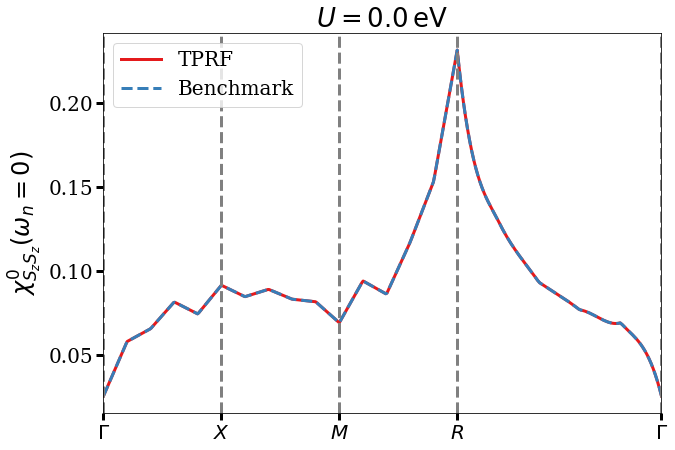

In [59]:
plt.plot(k_plot, interpolate_chi(SzSz_0, k_vecs).real, label='TPRF')
plt.plot(k_plot, interpolate_chi(bench_SzSz_0, k_vecs).real, linestyle="dashed", label='Benchmark')

plt.axes().set_xticks(K_plot)
for x in K_plot:
    plt.axvline(x, ls="--", color='grey')
plt.xlim([K_plot.min(), K_plot.max()])
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
plt.ylabel(r'$\chi_{S_zS_z}^0(\omega_n=0)$')
plt.legend()
plt.title(r'$U=0.0\,\mathrm{eV}$')

Text(0.5,1,'$U=1.0\\,\\mathrm{eV}$')

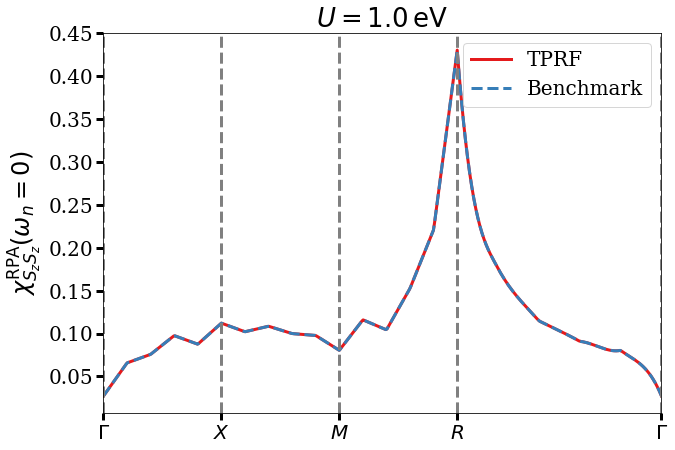

In [60]:
plt.plot(k_plot, interpolate_chi(SzSz_rpa, k_vecs).real, label='TPRF')
plt.plot(k_plot, interpolate_chi(bench_SzSz_rpa, k_vecs).real, linestyle="dashed", label='Benchmark')

plt.axes().set_xticks(K_plot)
for x in K_plot:
    plt.axvline(x, ls="--", color='grey')
plt.xlim([K_plot.min(), K_plot.max()])
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
plt.ylabel(r'$\chi_{S_zS_z}^{\mathrm{RPA}}(\omega_n=0)$')
plt.legend()
plt.title(r'$U=1.0\,\mathrm{eV}$')

## T2G Model

In [61]:
nk = 10

ham_t2g_parameters = {"k_mesh" : (nk, nk, nk),
                      "t" : 1.0,
                      "tprime" : 0.1,
                      "cf" : 0.5,
                      "soc" : 0.5,
                      "TRIQS": True,
                      "spin": True}
ham_t2g = T2G(**ham_t2g_parameters)

In [62]:
no = ham_t2g.hamK.shape[-1]

units = [(1,0,0), (0,1,0), (0,0,1)]
orbital_positions = [(0, 0, 0)]
bl = BravaisLattice(units, orbital_positions)
bz = BrillouinZone(bl)
periodization_matrix = nk * np.eye(3, dtype=np.int32)
kmesh = MeshBrillouinZone(bz, periodization_matrix)

e_k = Gf(mesh=kmesh, target_shape=[no, no])

e_k.data[:] = ham_t2g.hamK.reshape(nk**3, no, no)

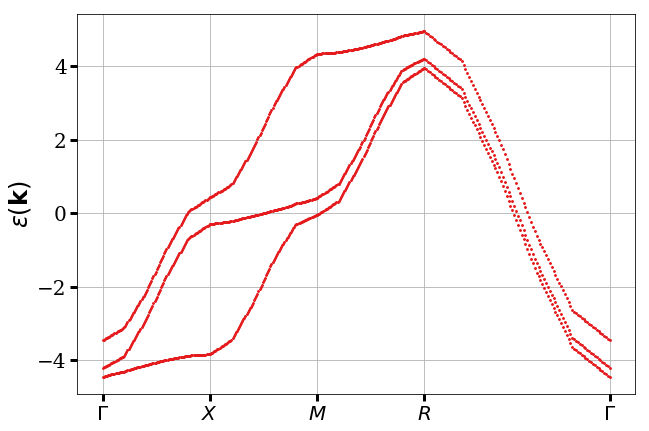

In [63]:
e_k_interp = np.array([np.linalg.eig(e_k([kxx, kyy, kzz]))[0].real for kxx,kyy,kzz in zip(kx,ky,kz)])

for i in range(6):
    plt.plot(k_plot, e_k_interp[:,i], '.', color='C0', markersize=3)
plt.axes().set_xticks(K_plot)
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
plt.ylabel(r'$\epsilon(\mathbf{k})$'); plt.grid()


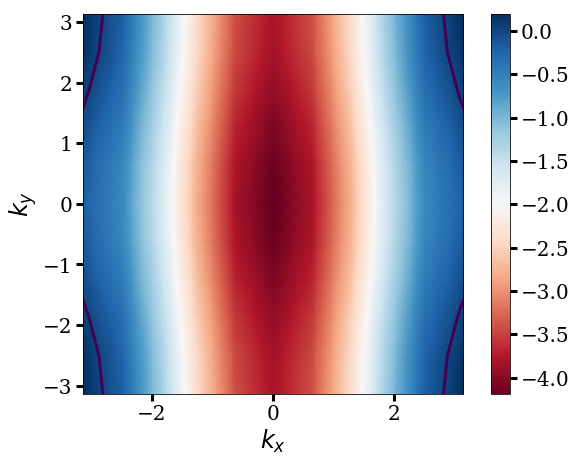

In [64]:
k = np.linspace(-0.5, 0.5, num=200) * 2. * np.pi
Kx, Ky = np.meshgrid(k, k)

e_k_interp = np.vectorize(lambda kx, ky : e_k([kx, ky, 0])[0, 0].real)
e_k_interp = e_k_interp(Kx, Ky)

plt.figure()
extent = (k.min(), k.max(), k.min(), k.max())
plt.imshow(e_k_interp, cmap=plt.get_cmap('RdBu'),
           extent=extent, origin='lower')
plt.colorbar()
plt.contour(Kx, Ky, e_k_interp, levels=[0], extent=extent)
plt.xlabel(r'$k_x$'); plt.ylabel(r'$k_y$');

In [65]:
wmesh = MeshImFreq(beta=10.0, S='Fermion', n_max=512)
g0_wk = lattice_dyson_g0_wk(mu=0.0, e_k=e_k, mesh=wmesh)

In [66]:
chi00_wk = imtime_bubble_chi0_wk(g0_wk, nw=1)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 10.0
nk    = 1000
nw    = 1024
norb  = 6

Approx. Memory Utilization: 2.77 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_w0r_from_grt_PH (bubble in tau & r)
--> chi_wk_from_chi_wr (r->k)


In [67]:
U = 1.0
J = 0.1

In [68]:
n_orb = 3
spin_names = ['up', 'do']
orb_names = range(n_orb)

gf_struct = [ [spin_name, orb_names] for spin_name in spin_names ]
Umat, Upmat = U_matrix_kanamori(n_orb=n_orb, U_int=U, J_hund=J)
H_int = h_int_kanamori(spin_names, orb_names, U=Umat, Uprime=Upmat, J_hund=J, off_diag=True)

fundamental_operators = fundamental_operators_from_gf_struct(gf_struct)

U_abcd = get_rpa_tensor(H_int, fundamental_operators)

For the multiorbital case the interaction has to be modified to fit the Hamiltonian input.
TRIQS uses a spin-block structure, e.g. $xy\uparrow$, $xz\uparrow$, $yz\uparrow$, $xy\downarrow$, $xz\downarrow$, $yz\downarrow$.
But the Hamiltonain is given as, $xy\uparrow$, $xy\downarrow$, $xz\uparrow$, $xz\downarrow$, $yz\uparrow$, $yz\downarrow$.
Therefore the array has to be modified.

In [69]:
mapping = {0 :0,
          1 : 3,
          2 : 1,
          3 : 4,
          4 : 2,
          5 : 5}

U_abcd_new = np.zeros_like(U_abcd)
for i,j,k,l in product(range(6), repeat=4):
    U_abcd_new[i,j,k,l] = U_abcd[mapping[i], mapping[j], mapping[k], mapping[l]]
U_abcd = U_abcd_new

In [70]:
# alternative get the interaction from rpa module
#from kanamori import KanamoriInteraction
#kanamori = KanamoriInteraction(orbitals=6, U_intra=1.0, U_inter=0.8, J=0.1, Jp=0.1)
#U_abcd = np.ascontiguousarray(4*np.swapaxes(kanamori.construct_tensor(), 1, 2))

In [71]:
chi_wk = solve_rpa_PH(chi00_wk, U_abcd)

In [72]:
def chi_SzSz_contraction(chi):
    """ Computes the trace Tr[ S_z \chi S_z ]"""
    Sz = np.diag([+0.5, -0.5, +0.5, -0.5, +0.5, -0.5])
    chi_SzSz = chi[0, 0, 0, 0].copy()
    chi_SzSz.data[:] = np.einsum('wqabcd,ab,cd->wq', chi.data, Sz, Sz)[:, :]
    chi_SzSz = chi_SzSz[Idx(0), :]
    return chi_SzSz

In [73]:
bench_chi00_wk = chi00_wk.copy()
bench_chi00_wk.data[:] = bench_chi0_t2g

bench_chi_wk = chi_wk.copy()
bench_chi_wk.data[:] = bench_chi_rpa_t2g

In [74]:
SzSz_0 = chi_SzSz_contraction(chi00_wk)
SzSz_rpa = chi_SzSz_contraction(chi_wk)

bench_SzSz_0 = chi_SzSz_contraction(bench_chi00_wk)
bench_SzSz_rpa = chi_SzSz_contraction(bench_chi_wk)

Text(0.5,1,'$U=0.0\\,\\mathrm{eV}$')

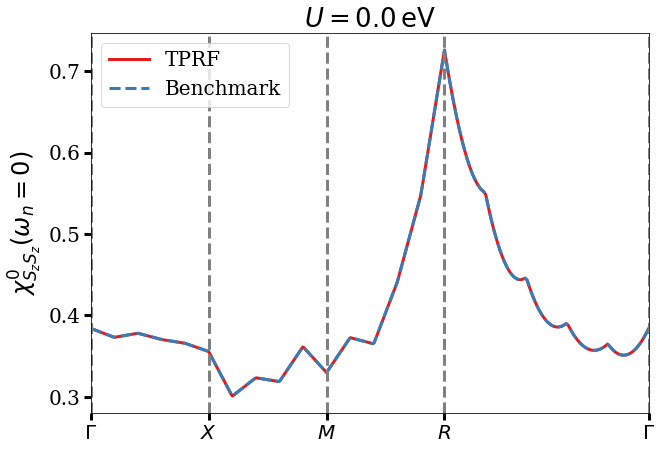

In [75]:
plt.plot(k_plot, interpolate_chi(SzSz_0, k_vecs).real, label='TPRF')
plt.plot(k_plot, interpolate_chi(bench_SzSz_0, k_vecs).real, linestyle="dashed", label='Benchmark')

plt.axes().set_xticks(K_plot)
for x in K_plot:
    plt.axvline(x, ls="--", color='grey')
plt.xlim([K_plot.min(), K_plot.max()])
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
plt.ylabel(r'$\chi_{S_zS_z}^0(\omega_n=0)$')
plt.legend()
plt.title(r'$U=0.0\,\mathrm{eV}$')

Text(0.5,1,'$U=1.0\\,\\mathrm{eV}$')

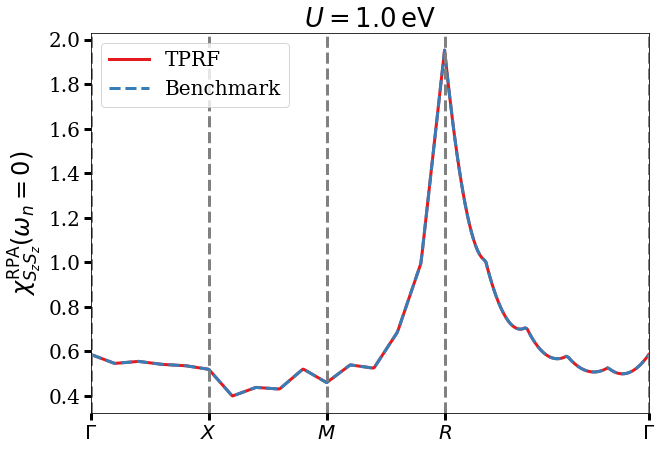

In [76]:
plt.plot(k_plot, interpolate_chi(SzSz_rpa, k_vecs).real, label='TPRF')
plt.plot(k_plot, interpolate_chi(bench_SzSz_rpa, k_vecs).real, linestyle="dashed", label='Benchmark')

plt.axes().set_xticks(K_plot)
for x in K_plot:
    plt.axvline(x, ls="--", color='grey')
plt.xlim([K_plot.min(), K_plot.max()])
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$', r'$R$',r'$\Gamma$'])
plt.ylabel(r'$\chi_{S_zS_z}^{\mathrm{RPA}}(\omega_n=0)$')
plt.legend()
plt.title(r'$U=1.0\,\mathrm{eV}$')